# Initialize

In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

/opt/conda/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [2]:
import sys

sys.path.insert(0, '../../')


adsorbate = 'CO'
target_energy = -0.67
initial_training_size = 1000
batch_size = 200
quantile_cutoff = 0.95

In [3]:
import random
import ase.db


db_dir = '../pull_data/%s/' % adsorbate
db = ase.db.connect(db_dir + '%s.db' % adsorbate)
rows = list(db.select())
random.Random(42).shuffle(rows)


def parse_rows(rows):
    features = []
    labels = []
    surfaces = []

    for row in rows:
        features.append(row.id)
        data = row.data
        labels.append(data['adsorption_energy'])
        surface = (data['mpid'], data['miller'], data['shift'], data['top'])
        surfaces.append(surface)

    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

# Random Sampling Procedures

### Random Sampling with Null Model

In [4]:
cd ../random/null

/home/jovyan/proj/catalyst-acquisitions/notebooks/random/null


### Loaded preprocessed data from:  ['../../pull_data/CO/data.pt']


(<Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>)

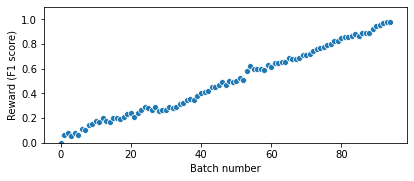

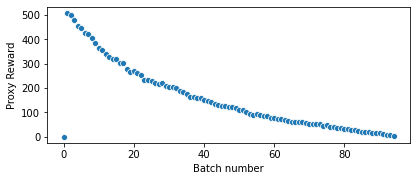

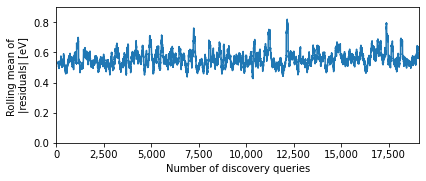

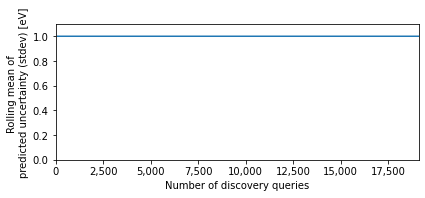

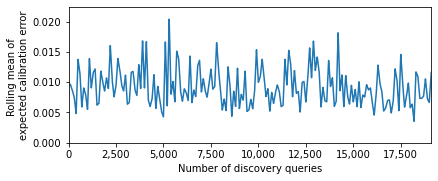

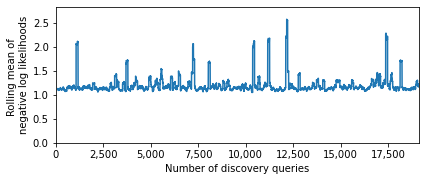

In [5]:
sys.path.insert(0, '../../..')

from src.discoverers.adsorption.models import NullModel
from src.discoverers.adsorption.randomsearch import RandomSearcher
from src.discoverers.adsorption.values import calc_co2rr_activities

db_dir = '../../pull_data/%s/' % adsorbate

model = NullModel(db_dir, quantile_cutoff)
rs_null_discoverer = RandomSearcher(model=model,
                                    quantile_cutoff=quantile_cutoff,
                                    value_calculator=calc_co2rr_activities,
                                    batch_size=batch_size,
                                    training_features=training_features,
                                    training_labels=training_labels,
                                    training_surfaces=training_surfaces,
                                    sampling_features=sampling_features,
                                    sampling_labels=sampling_labels,
                                    sampling_surfaces=sampling_surfaces,
                                    #n_samples=3,  # decrease to speed up
                                    #init_train=False  # Set to `False` only for warm starts
                                    )

# rs_null_discoverer.simulate_discovery()

rs_null_discoverer.load_last_run()

rs_null_discoverer.plot_performance(window=100)

### Random sampling with CFGP (NOTE: uses prime for now until I cache files)

In [6]:
cd ../prime

/home/jovyan/proj/catalyst-acquisitions/notebooks/random/prime


### Loaded preprocessed data from:  ['../../pull_data/CO/data.pt']


../../../src/discoverers/base.py:426: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  _ = ax.set_ylim([0., np.nanmax(rolled_values) * 1.1])


(<Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>)

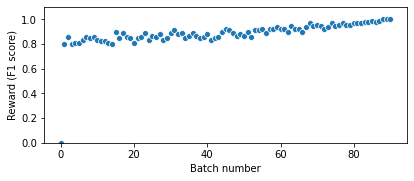

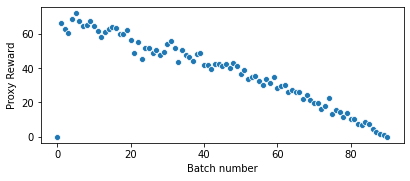

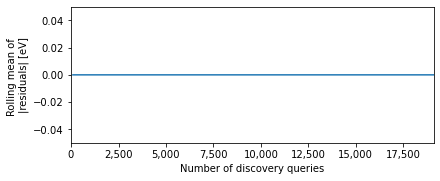

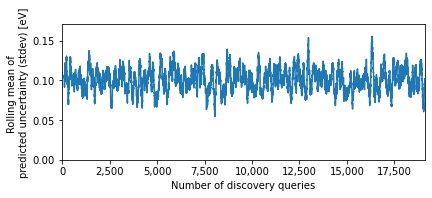

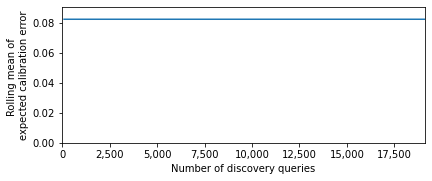

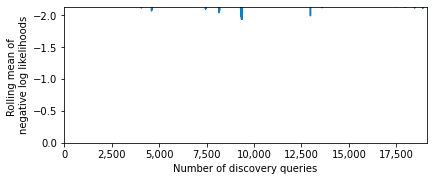

In [7]:
from src.discoverers.adsorption.models import PrimeModel


model = PrimeModel(db_dir)
rs_cfgp_discoverer = RandomSearcher(model=model,
                                    quantile_cutoff=quantile_cutoff,
                                    value_calculator=calc_co2rr_activities,
                                    batch_size=batch_size,
                                    training_features=training_features,
                                    training_labels=training_labels,
                                    training_surfaces=training_surfaces,
                                    sampling_features=sampling_features,
                                    sampling_labels=sampling_labels,
                                    sampling_surfaces=sampling_surfaces,
                                    #n_samples=3,  # decrease to speed up
                                    #init_train=False  # Set to `False` only for warm starts
                                    )

# rs_cfgp_discoverer.simulate_discovery()

rs_cfgp_discoverer.load_last_run()

rs_cfgp_discoverer.plot_performance(window=100)

# MMS Procedures

### MMS with null model

In [8]:
cd ../../MMS/null

/home/jovyan/proj/catalyst-acquisitions/notebooks/MMS/null


### Loaded preprocessed data from:  ['../../pull_data/CO/data.pt']


(<Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>)

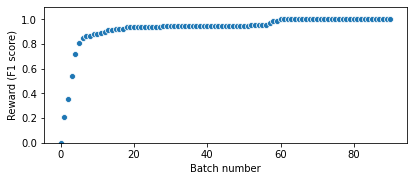

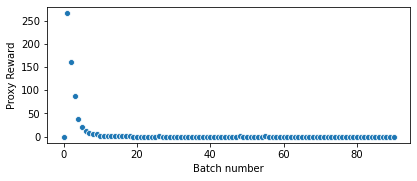

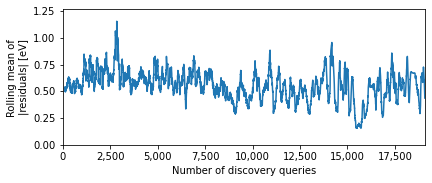

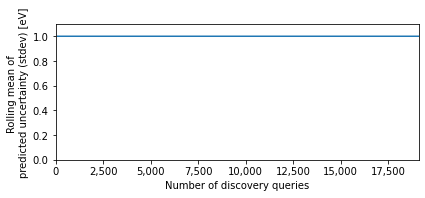

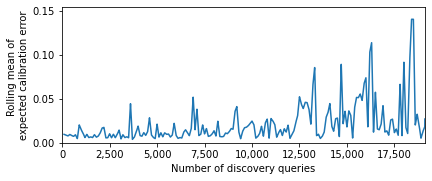

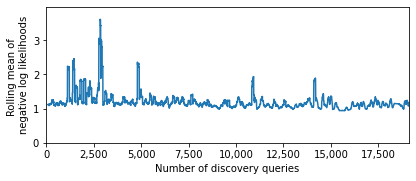

In [9]:
sys.path.insert(0, '../../..')

from src.discoverers.adsorption.mms import MultiscaleDiscoverer
from src.discoverers.adsorption.models import NullModel


db_dir = '../../pull_data/%s/' % adsorbate

model = NullModel(db_dir, quantile_cutoff)
mms_null_discoverer = MultiscaleDiscoverer(model=model,
                                           quantile_cutoff=quantile_cutoff,
                                           value_calculator=calc_co2rr_activities,
                                           batch_size=batch_size,
                                           training_features=training_features,
                                           training_labels=training_labels,
                                           training_surfaces=training_surfaces,
                                           sampling_features=sampling_features,
                                           sampling_labels=sampling_labels,
                                           sampling_surfaces=sampling_surfaces,
                                           #n_samples=3,  # decrease to speed up
                                           init_train=False  # Set to `False` only for warm starts
                                          )

# mms_null_discoverer.simulate_discovery()

mms_null_discoverer.load_last_run()

mms_null_discoverer.plot_performance(window=100)

### MMS with CFGP

In [10]:
cd ../CFGP

/home/jovyan/proj/catalyst-acquisitions/notebooks/MMS/CFGP


### Loaded preprocessed data from:  ['../../pull_data/CO/data.pt']
cmd:
  checkpoint_dir: /home/jovyan/proj/catalyst-acquisitions/notebooks/MMS/CFGP/checkpoints/2020-09-21-07-52-17-cnn
  identifier: cnn
  logs_dir: /home/jovyan/proj/catalyst-acquisitions/notebooks/MMS/CFGP/logs/tensorboard/2020-09-21-07-52-17-cnn
  print_every: 100
  results_dir: /home/jovyan/proj/catalyst-acquisitions/notebooks/MMS/CFGP/results/2020-09-21-07-52-17-cnn
  seed: null
  timestamp: 2020-09-21-07-52-17-cnn
dataset:
  src: ../../pull_data/CO/
  test_size: 0
  train_size: 1000
  val_size: 0
logger: tensorboard
model: cgcnn
model_attributes:
  atom_embedding_size: 64
  fc_feat_size: 128
  num_fc_layers: 4
  num_graph_conv_layers: 6
  regress_forces: false
optim:
  batch_size: 64
  lr_gamma: 0.1
  lr_initial: 0.001
  lr_milestones:
  - 25
  - 45
  max_epochs: 50
  num_gpus: 4
  warmup_epochs: 10
  warmup_factor: 0.2
task:
  dataset: gasdb
  description: Regression of DFT calculated binding energes
  labels:
  -

/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Iter 1/100 - Loss: 1.270   lengthscale: 0.709   noise: 0.672
Iter 2/100 - Loss: 1.175   lengthscale: 0.735   noise: 0.597
Iter 3/100 - Loss: 1.121   lengthscale: 0.761   noise: 0.531
Iter 4/100 - Loss: 1.011   lengthscale: 0.830   noise: 0.396
Iter 5/100 - Loss: 0.928   lengthscale: 0.932   noise: 0.296
Iter 6/100 - Loss: 0.892   lengthscale: 1.009   noise: 0.254
Iter 7/100 - Loss: 0.804   lengthscale: 1.256   noise: 0.177
Iter 8/100 - Loss: 0.768   lengthscale: 1.417   noise: 0.151
Iter 9/100 - Loss: 0.749   lengthscale: 1.517   noise: 0.142
Iter 10/100 - Loss: 0.734   lengthscale: 1.653   noise: 0.133
Iter 11/100 - Loss: 0.704   lengthscale: 1.865   noise: 0.127
Iter 12/100 - Loss: 0.706   lengthscale: 1.865   noise: 0.127
Convergence reached!
Finished training on 1000 data points using 4 GPUs.


/opt/conda/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


cmd:
  checkpoint_dir: /home/jovyan/proj/catalyst-acquisitions/notebooks/MMS/CFGP/checkpoints/2020-09-21-07-55-47-cnn
  identifier: cnn
  logs_dir: /home/jovyan/proj/catalyst-acquisitions/notebooks/MMS/CFGP/logs/tensorboard/2020-09-21-07-55-47-cnn
  print_every: 100
  results_dir: /home/jovyan/proj/catalyst-acquisitions/notebooks/MMS/CFGP/results/2020-09-21-07-55-47-cnn
  seed: null
  timestamp: 2020-09-21-07-55-47-cnn
dataset:
  src: ../../pull_data/CO/
  test_size: 0
  train_size: 1
  val_size: 0
logger: tensorboard
model: cgcnn
model_attributes:
  atom_embedding_size: 64
  fc_feat_size: 128
  num_fc_layers: 4
  num_graph_conv_layers: 6
  regress_forces: false
optim:
  batch_size: 64
  lr_gamma: 0.1
  lr_initial: 0.001
  lr_milestones:
  - 25
  - 45
  max_epochs: 50
  num_gpus: 4
  warmup_epochs: 10
  warmup_factor: 0.2
task:
  dataset: gasdb
  description: Regression of DFT calculated binding energes
  labels:
  - binding energy
  metric: mae
  type: regression

### Loading dataset:

(<Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>,
 <Figure size 468x180 with 1 Axes>)

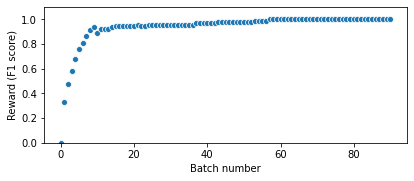

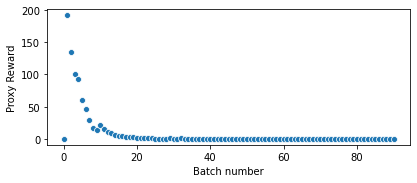

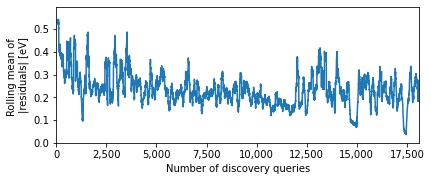

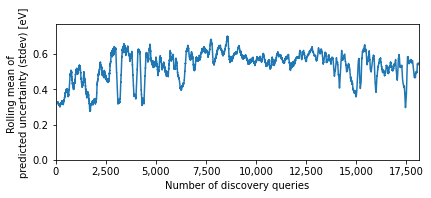

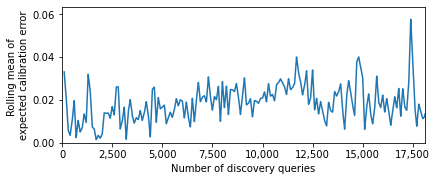

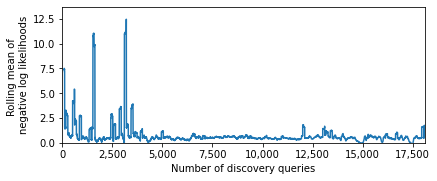

In [11]:
import os
os.environ['PYTHONPATH'] = '/home/jovyan/GASpy:/home/jovyan/GASpy/GASpy_regressions:'

import sys
sys.path.insert(0, '/home/jovyan/GASpy')
sys.path.insert(0, '/home/jovyan/GASpy/GASpy_regressions')

sys.path.append('../../..')
from src.discoverers.adsorption.mms import MultiscaleDiscoverer
from src.discoverers.adsorption.models import CFGP
from src.discoverers.adsorption.values import calc_co2rr_activities


# Initialize
model = CFGP(db_dir)
mms_cfgp_discoverer = MultiscaleDiscoverer(model=model,
                                           value_calculator=calc_co2rr_activities,
                                           quantile_cutoff=quantile_cutoff,
                                           batch_size=batch_size,
                                           training_features=training_features,
                                           training_labels=training_labels,
                                           training_surfaces=training_surfaces,
                                           sampling_features=sampling_features,
                                           sampling_labels=sampling_labels,
                                           sampling_surfaces=sampling_surfaces,
                                           #init_train=False  # Set to `False` only for warm starts
                                           )

# mms_cfgp_discoverer.simulate_discovery()

mms_cfgp_discoverer.load_last_run()

mms_cfgp_discoverer.plot_performance(window=100)

# Comparison

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import pandas as pd


FORMATTER = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
FIG_SIZE = (6.5, 2.5)


def plot_rolling_metric(ax, metric_values, metric_name, label=None,
                        window=200, smoother='mean', unit=''):
    '''
    Helper function to plot model performance metrics across time in
    hallucination.

    Args:
        ax              Matplotlib ax object to plot onto
        metric_values   A sequence of floats that will be plotted against
                        batch number in the hallucination.
        metric_name     A string indicating what you want the values to be
                        labeled as in the plots.
        label           A string indicating the label you want to use for
                        the data
        window          How many points to roll over during each iteration
        smoother        String indicating how you want to smooth the
                        residuals over the course of the hallucination.
                        Corresponds exactly to the methods of the
                        `pandas.DataFrame.rolling` class, e.g., 'mean',
                        'median', 'min', 'max', 'std', 'sum', etc.
        unit            [Optional] String indicating the units you want to
                        label the plot with
    '''
    # Format the data
    df = pd.DataFrame(metric_values, columns=[metric_name])
    rolling_residuals = getattr(df, metric_name).rolling(window=window)
    rolled_values = getattr(rolling_residuals, smoother)().values
    query_numbers = list(range(len(rolled_values)))

    # Create and format the figure
    _ = sns.lineplot(query_numbers, rolled_values, ax=ax, label=label)
    _ = ax.set_xlabel('Number of discovery queries')
    if unit:
        unit = ' [' + unit + ']'
    _ = ax.set_ylabel('Rolling %s of \n%s%s' % (smoother, metric_name, unit))
    _ = ax.set_xlim([query_numbers[0], query_numbers[-1]])
    _ = ax.set_ylim([0., np.nanmax(rolled_values) * 1.1])
    _ = fig.set_size_inches(*FIG_SIZE)
    _ = ax.get_xaxis().set_major_formatter(FORMATTER)
    return fig

### F1 Score

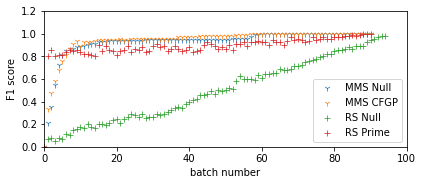

In [17]:
fig = plt.figure()

ax_mms_null = sns.scatterplot(list(range(len(mms_null_discoverer.reward_history))),
                              mms_null_discoverer.reward_history,
                              label='MMS Null', marker='1')
ax_mms_cfgp = sns.scatterplot(list(range(len(mms_cfgp_discoverer.reward_history))),
                              mms_cfgp_discoverer.reward_history,
                              label='MMS CFGP', marker='1')
ax_rs_null = sns.scatterplot(list(range(len(rs_null_discoverer.reward_history))),
                             rs_null_discoverer.reward_history,
                             label='RS Null', marker='+')
ax_rs_cfgp = sns.scatterplot(list(range(len(rs_cfgp_discoverer.reward_history))),
                             rs_cfgp_discoverer.reward_history,
                             label='RS Prime', marker='+')
# ax_tpot = sns.scatterplot(list(range(len(tpot_discoverer.reward_history))),
#                           tpot_discoverer.reward_history,
#                           label='GASpy (old)', marker='x')
# ax_null = sns.scatterplot(list(range(len(null_discoverer.reward_history))),
#                           null_discoverer.reward_history,
#                           label='RS w/ $∅$', marker='.')

_ = ax_mms_null.set_xlabel('batch number')
_ = ax_mms_null.set_ylabel('F1 score')
_ = ax_mms_null.set_xlim(0, 100)
_ = ax_mms_null.set_ylim(0., 1.2)
_ = fig.set_size_inches(*FIG_SIZE)
_ = ax_mms_null.get_xaxis().set_major_formatter(FORMATTER)

### Residuals

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


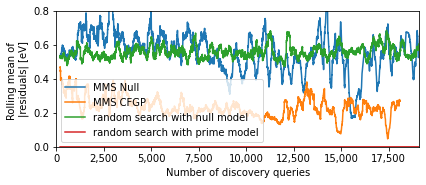

In [18]:
fig = plt.figure()
ax = fig.gca()

_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(mms_null_discoverer.residuals),
                        label='MMS Null',
                        metric_name='|residuals|',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(mms_cfgp_discoverer.residuals),
                        label='MMS CFGP',
                        metric_name='|residuals|',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(rs_null_discoverer.residuals),
                        label='random search with null model',
                        metric_name='|residuals|',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(rs_cfgp_discoverer.residuals),
                        label='random search with prime model',
                        metric_name='|residuals|',
                        unit='eV')
# _ = plot_rolling_metric(ax=ax,
#                         metric_values=np.abs(tpot_discoverer.residuals),
#                         label='GASpy heuristic',
#                         metric_name='|residuals|',
#                         unit='eV')

_ = ax.set_ylim([0., 0.8])

### Sharpness

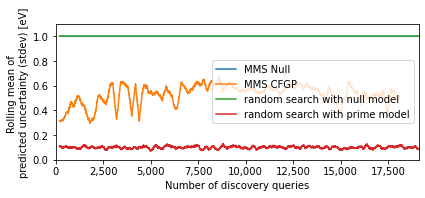

In [25]:
fig = plt.figure()
ax = fig.gca()

_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(mms_null_discoverer.uncertainties),
                        label='MMS Null',
                        metric_name='predicted uncertainty (stdev)',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(mms_cfgp_discoverer.uncertainties),
                        label='MMS CFGP',
                        metric_name='predicted uncertainty (stdev)',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(rs_null_discoverer.uncertainties),
                        label='random search with null model',
                        metric_name='predicted uncertainty (stdev)',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(rs_cfgp_discoverer.uncertainties),
                        label='random search with prime model',
                        metric_name='predicted uncertainty (stdev)',
                        unit='eV')
#_ = plot_rolling_metric(ax=ax,
#                        metric_values=tpot_discoverer.uncertainties,
#                        label='GASpy heuristic',
#                        metric_name='predicted uncertainty (stdev)',
#                        unit='eV')

_ = ax.set_ylim([0., 1.1])

### Calibration

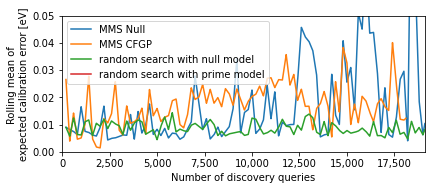

In [26]:
from tqdm.notebook import tqdm


fig = plt.figure()
ax = fig.gca()


def calculate_eces(discoverer, window=200):
    # Divide the data into chunks, which we need to calculate ECE
    chunked_residuals = discoverer.chunk_iterable(discoverer.residuals, window)
    chunked_uncertainties = discoverer.chunk_iterable(discoverer.uncertainties, window)

    # Calculate ECE
    loop = tqdm(zip(chunked_residuals, chunked_uncertainties),
                desc='calibration', unit='batch', total=len(chunked_residuals))
    for resids, stdevs in loop:
        ece = discoverer.calculate_expected_calibration_error(resids, stdevs)
        try:
            eces.extend([ece] * len(resids))
        # EAFP for initialization
        except NameError:
            eces = [ece] * len(resids)
    return eces


_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_eces(mms_null_discoverer),
                        label='MMS Null',
                        metric_name='expected calibration error',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_eces(mms_cfgp_discoverer),
                        label='MMS CFGP',
                        metric_name='expected calibration error',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_eces(rs_null_discoverer),
                        label='random search with null model',
                        metric_name='expected calibration error',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_eces(rs_cfgp_discoverer),
                        label='random search with prime model',
                        metric_name='expected calibration error',
                        unit='eV')
#_ = plot_rolling_metric(ax=ax,
#                        metric_values=calculate_eces(tpot_discoverer),
#                        label='GASpy heuristic',
#                        metric_name='expected calibration error')

_ = ax.set_ylim([0., 0.05])

### NLL

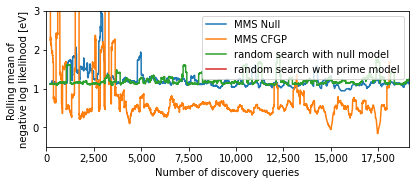

In [27]:
from scipy.stats import norm


fig = plt.figure()
ax = fig.gca()


def calculate_nlls(discoverer):
    nlls = [-norm.logpdf(resid, loc=0., scale=std)
            for resid, std in zip(discoverer.residuals, discoverer.uncertainties)]
    return nlls


_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_nlls(mms_null_discoverer),
                        label='MMS Null',
                        metric_name='negative log likelihood',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_nlls(mms_cfgp_discoverer),
                        label='MMS CFGP',
                        metric_name='negative log likelihood',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_nlls(rs_null_discoverer),
                        label='random search with null model',
                        metric_name='negative log likelihood',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_nlls(rs_cfgp_discoverer),
                        label='random search with prime model',
                        metric_name='negative log likelihood',
                        unit='eV')
#_ = plot_rolling_metric(ax=ax,
#                        metric_values=calculate_nlls(tpot_discoverer),
#                        label='GASpy heuristic',
#                        metric_name='negative log likelihood',
#                        window=400)

_ = ax.set_ylim([-0.5, 3.])